In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp                
import scipy.io
import scipy.linalg 

## Increase of convergence rate for transformed SDE in the case of double well?

Potential: 
$$
V(x) = (x^2-1)^2
$$

and derivative of potential: 
$$
V'(x) = 4x(x^2-1)
$$


In [3]:
#define DIVTERM          //define to use
m=0.001      #     // minimum step scale factor
M=1.5       #       // maximum step scale factor
dt=0.0005     #      // artificial time stepsize
gamma=0.1         #   // friction coefficient
tau=0.1          #  // 'temperature'
numruns=8000         # // total number of trajectories
numsam=10  
r=0.01
nsnapshot=5

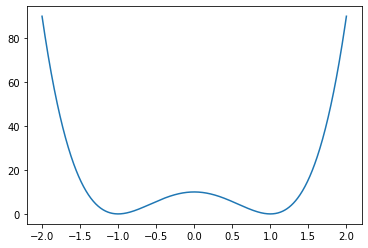

In [4]:
s1=10
r=1
def gfunc(x):
    f=1/(x*x-1)
    fabs=abs(f)
    fabs2=fabs*fabs
    xi=fabs2*fabs2*r+m*m
    g=1/(1/M+1/np.sqrt(xi))
    return g

def getgprime(x):
    xx21=x*x-1
    f=1/(x*x-1)
    fp = 2*x/(xx21*xx21);
    xi=np.sqrt(r*f*f*f*f+m*m)
    den1=xi*xi*xi
    den2=(1/xi+1/M)
    num = 2*f*fp*f*f
    gprime=num/(den1*den2*den2)
    return(gprime)

def getU(x):
    res =s1*np.power(x*x-1,2)
    return res

def Up(x):
    res =4*s1*(x*x-1)*x
    return res

s=np.linspace(-2,2,1000)
plt.plot(s,getU(s))


### Write Euler Maruyama for transformed and non transfromed SDE

Text(0.5, 1.0, 'One trajectory')

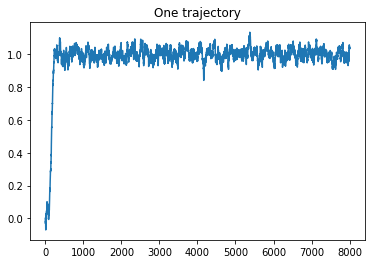

In [5]:
# def Up(x):
#     f=6*np.power(x,5)-20*np.power(x,3)+12*x+1
#     return f
def Up(x):
    res =4*s1*(x*x-1)*x
    return res

def run_sample(dt,Nt,x0):
    n_sample = np.shape(x0)[0]
    x_traj = np.zeros((n_sample,Nt))
    sq2=np.sqrt(2*dt*tau)
    for j in range(Nt):
        x_traj[:,j]=x0
        dw=np.random.randn(n_sample)
        x0+=-Up(x0)*dt+sq2*dw

    return(x_traj)

def run_sample_tr(dt,Nt,x0):
    n_sample = np.shape(x0)[0]
    x_traj = np.zeros((n_sample,Nt))
    sq2=np.sqrt(2*dt*tau)
    for j in range(Nt):
        x_traj[:,j]=x0
        dw=np.random.randn(n_sample)
        x0+=-Up(x0)*gfunc(x0)*dt+dt*getgprime(x0)*tau+sq2*dw*np.sqrt(gfunc(x0))

    return(x_traj)

# dt=0.001
Nt=8000
x0=np.ones(1)*0
traj = run_sample(dt,Nt,x0)
t=np.linspace(1,Nt+1,Nt)
plt.plot(t,traj[0])
plt.title("One trajectory")

### Write function for EDMD algorithms

In [6]:
# Edmd algorithm 
def sortEig(A):
    eigenValues, eigenVectors = np.linalg.eig(A)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    return eigenValues, eigenVectors

def phi(x, power):
    return (np.vstack([x]*len(power)).T**power).T

def edmd(X, Y, phi, degrees): 
    PhiX = phi(X, degrees)
    PhiY = phi(Y, degrees)
    C_0 = PhiX @ PhiX.T
    C_1 = PhiX @ PhiY.T 
    A = sp.linalg.pinv(C_0) @ C_1 
    d, V = sortEig(A)
    return A, d, V


## Non adaptive SDE: results

Text(0.5, 1.0, 'Histogram of samples after 1000 steps using h=0.001')

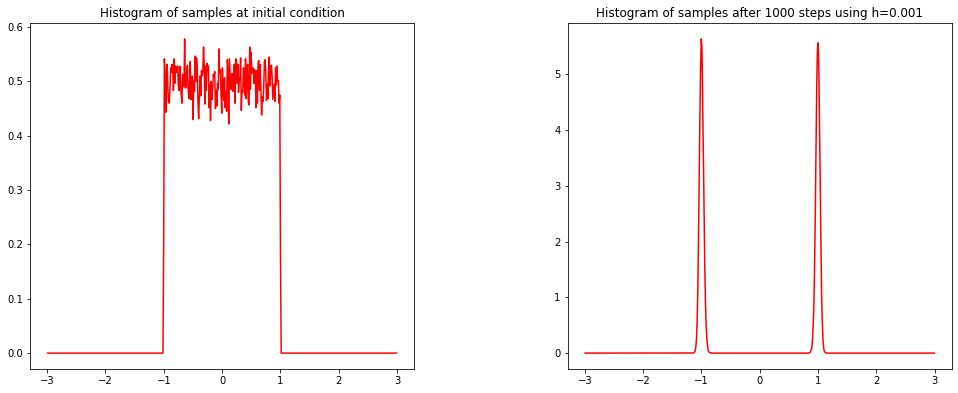

In [7]:
dt=0.0005
Nt=500
size_sample=50000
x0=np.random.uniform(-1,1,size_sample)
traj_edmd = run_sample(dt,Nt,x0)
X = traj_edmd[:,0]
Y = traj_edmd[:,-1]
fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)


## intitial

histogram,bins = np.histogram(X,bins=500,range=[-3,3], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='sde',color="red")
ax1.set_title("Histogram of samples at initial condition")

## final
histogram,bins = np.histogram(Y,bins=500,range=[-3,3], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_q,histogram,label='sde',color="red")
ax2.set_title("Histogram of samples after 1000 steps using h=0.001")


In [8]:
power = list(range(11))
[K, d, V] = edmd(X, Y, phi, power)

Spectral gap: 

0.3828920284126296


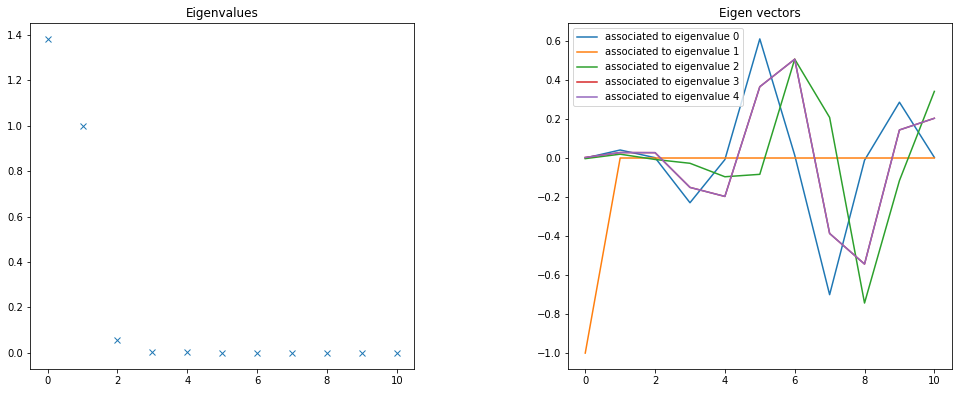

In [9]:

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)

ax1.plot(np.real(d),"x")
ax1.set_title("Eigenvalues")

for i in range(5):
    ax2.plot(np.real(V[:,i]),label="associated to eigenvalue "+str(i))
ax2.legend()
ax2.set_title("Eigen vectors")

spectral_gap = np.real(d)[0]-np.real(d)[1]
print("Spectral gap: \n")
print(spectral_gap)

# Transformed 

Text(0.5, 1.0, 'Histogram of samples after 1000 steps using h=0.001')

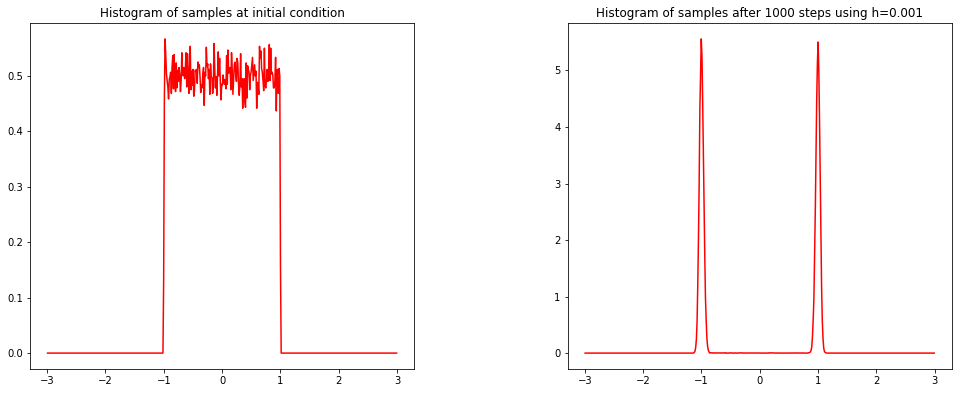

In [10]:

# transformed

dt=0.0005
Nt=500
size_sample=50000
x0=np.random.uniform(-1,1,size_sample)
traj_edmd_tr = run_sample_tr(dt,Nt,x0)
Xtr = traj_edmd_tr[:,0]
Ytr = traj_edmd_tr[:,-1]

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)


## p
histogram,bins = np.histogram(Xtr,bins=500,range=[-3,3], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='sde',color="red")
ax1.set_title("Histogram of samples at initial condition")

## p
histogram,bins = np.histogram(Ytr,bins=500,range=[-3,3], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_q,histogram,label='sde',color="red")
ax2.set_title("Histogram of samples after 1000 steps using h=0.001")



Spectral gap:

0.42257485556346397


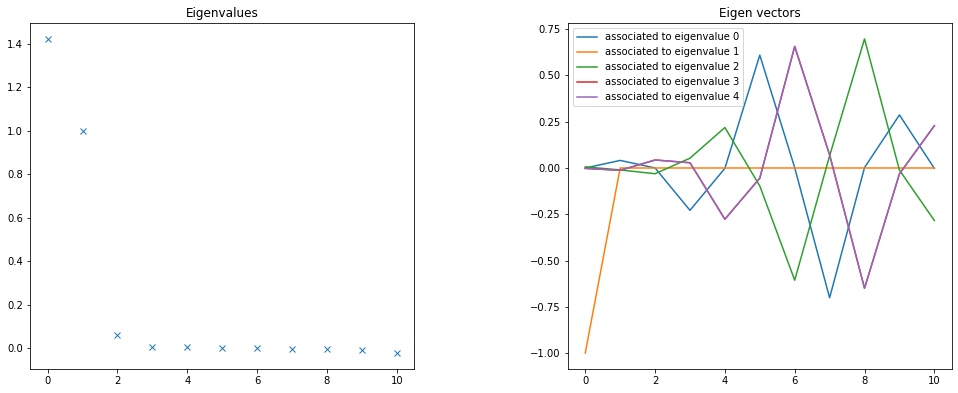

In [12]:
power = list(range(11))
[Ktr, dtr, Vtr] = edmd(Xtr, Ytr, phi, power)


fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)

ax1.plot(np.real(dtr),"x")
ax1.set_title("Eigenvalues")

for i in range(5):
    ax2.plot(np.real(Vtr[:,i]),label="associated to eigenvalue "+str(i))
ax2.legend()
ax2.set_title("Eigen vectors")

spectral_gap = np.real(dtr)[0]-np.real(dtr)[1]
print("Spectral gap:\n")
print(spectral_gap)

We obtain 2 dominant eigenvalues corresponding to the slow dynamics.


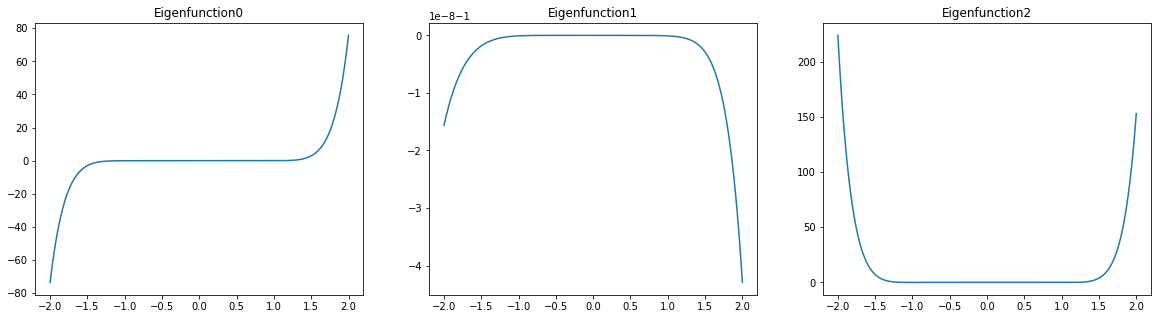

In [13]:
def eigenfunction(x,eigVec):
    eigVec = np.real(eigVec)    
    res= eigVec[0] + eigVec[1]*x + eigVec[2]*pow(x, 2) + eigVec[3]*pow(x, 3) + eigVec[4]*pow(x, 4) + eigVec[4]*pow(x, 4) + eigVec[5]*pow(x, 5) + eigVec[6]*pow(x, 6) + eigVec[7]*pow(x, 7) + eigVec[8]*pow(x, 8) + eigVec[9]*pow(x, 9) + eigVec[10]*pow(x, 10)
    return res

num_eigenvec=3
x=np.linspace(-2,2.,1000)
fig, (axs)= plt.subplots(1, num_eigenvec,figsize=(20,5))# plt.figure(figsize=(4,4))
for i in range(num_eigenvec):
    axs[i].plot(x,eigenfunction(x,V[:,i]))
    axs[i].set_title("Eigenfunction"+str(i))